In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.utils import check_array
from keras.models import load_model
from keras.layers import Bidirectional
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from numpy import array
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.layers import Dense,LSTM,Dropout,Activation
import os
from sklearn.metrics import mean_absolute_percentage_error
from pandas import DataFrame

In [2]:
df=pd.read_csv('alpha_death.csv')
df.head()

death
0  10188
1  21045
2  34160
3  48371
4  62715

In [3]:
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):] 

In [4]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_5796/3151536076.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_5796/3151536076.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [5]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [48]:
n_past = 5
n_future =7
n_features = 1

In [49]:
X_train, y_train = split_series(train.values,n_past, n_future)

In [50]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [56]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 5, 1)]       0           []                               
                                                                                                  
 lstm_8 (LSTM)                  [(None, 5, 100),     40800       ['input_3[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_9 (LSTM)                  [(None, 100),        80400       ['lstm_8[0][0]']                 
                                 (None, 100),                                               

In [57]:

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history=model.fit(X_train,y_train,epochs=100,validation_split = 0.2,batch_size=16,verbose=0)

In [17]:
model=load_model("LSTM_3days.h5")
#model=model.save("LSTM_3days.h5")

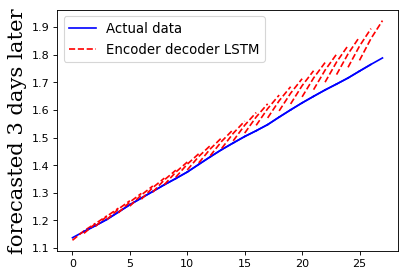

In [18]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

pred3LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}


for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3LSTM[i],"red",linestyle='dashed')
    #plt.title("Encoder decoder LSTM", fontdict = font1)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 3 days later", fontdict = font1)
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)
    


In [19]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

death
Day  1 :
MAE-E2D2 :  0.013547572769003877
Day  2 :
MAE-E2D2 :  0.041421765976648824
Day  3 :
MAE-E2D2 :  0.061551098273131766


mean 0.03884014567292816


In [22]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    

death
Day  1 :
MAE-E2D2 :  0.8664463857443075
Day  2 :
MAE-E2D2 :  2.638242997080752
Day  3 :
MAE-E2D2 :  3.872905583848986


mean 2.459198322224682


In [23]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   



death
Day  1 :
MAE-E2D2 :  0.018096286509520255
Day  2 :
MAE-E2D2 :  0.05000327744830597
Day  3 :
MAE-E2D2 :  0.07331704162981437


mean 0.04713886852921353


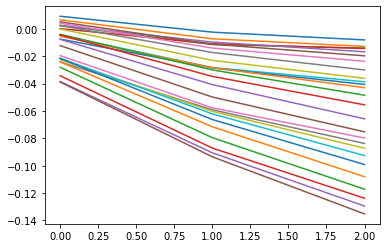

In [26]:
#residual plot

residuals = y_test-pred3LSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)
    

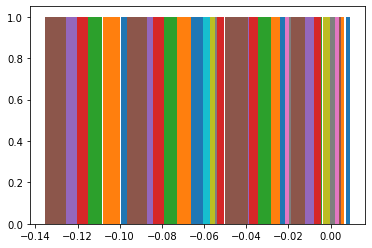

In [27]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

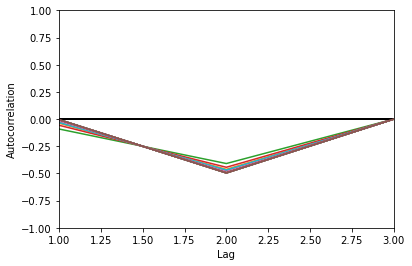

In [28]:
from pandas.plotting import autocorrelation_plot
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)

In [42]:
model=load_model("LSTM_5days.h5")
#model=model.save("LSTM_5days.h5")

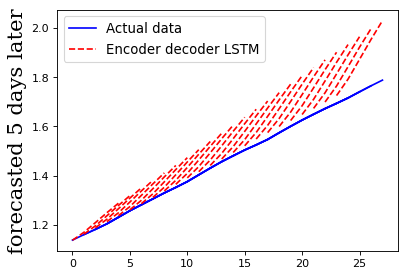

In [43]:
pred5LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5LSTM[i],"red",linestyle='dashed')
    plt.ylabel("forecasted 5 days later", fontdict = font1)
    #plt.xlabel("days")   
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)
#plt.legend()

In [44]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

death
Day  1 :
MAE-E2D2 :  0.014381256650797833
Day  2 :
MAE-E2D2 :  0.03896621537620885
Day  3 :
MAE-E2D2 :  0.0740642529594754
Day  4 :
MAE-E2D2 :  0.1100443487465469
Day  5 :
MAE-E2D2 :  0.14350058386757772


mean 0.07619133152012134


In [35]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  0.9584713043008288
Day  2 :
MAE-E2D2 :  2.5864237327505673
Day  3 :
MAE-E2D2 :  4.873261496767748
Day  4 :
MAE-E2D2 :  7.145154955830652
Day  5 :
MAE-E2D2 :  9.179774670257833


mean 4.948617231981525


In [36]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   


death
Day  1 :
MAE-E2D2 :  0.01698759287338101
Day  2 :
MAE-E2D2 :  0.04359102330172069
Day  3 :
MAE-E2D2 :  0.08076142881205395
Day  4 :
MAE-E2D2 :  0.11890369199780662
Day  5 :
MAE-E2D2 :  0.154558465394348


mean 0.08296044047586207


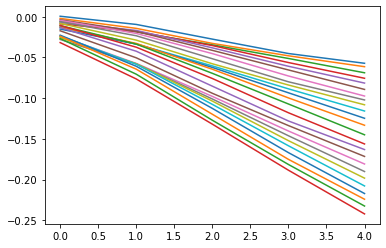

In [45]:
#residual plot

residuals = y_test-pred5LSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)
    

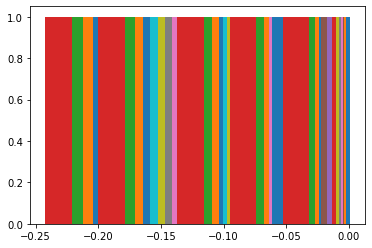

In [46]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

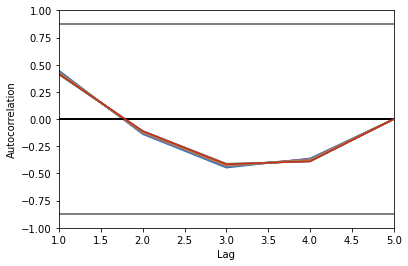

In [47]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)

In [60]:
model=load_model("LSTM_7days.h5")
#model=model.save("LSTM_7days.h5")

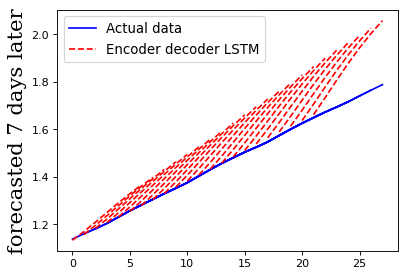

In [61]:
pred7LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7LSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    plt.ylabel("forecasted 7 days later", fontdict = font1)
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)


In [62]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  0.005952470932581535
Day  2 :
MAE-E2D2 :  0.033458876057079395
Day  3 :
MAE-E2D2 :  0.06518247622393587
Day  4 :
MAE-E2D2 :  0.09671286644307014
Day  5 :
MAE-E2D2 :  0.12621738811771674
Day  6 :
MAE-E2D2 :  0.15256860211350337
Day  7 :
MAE-E2D2 :  0.1750239666753207


mean 0.09358809236617253


In [63]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  0.4031568812992424
Day  2 :
MAE-E2D2 :  2.269962043941384
Day  3 :
MAE-E2D2 :  4.382713941752766
Day  4 :
MAE-E2D2 :  6.4183750369616375
Day  5 :
MAE-E2D2 :  8.258234711975229
Day  6 :
MAE-E2D2 :  9.839114698242343
Day  7 :
MAE-E2D2 :  11.124033616768703


mean 6.0993701329916155


In [55]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   


death
Day  1 :
MAE-E2D2 :  0.007865380473083017
Day  2 :
MAE-E2D2 :  0.03713836819429871
Day  3 :
MAE-E2D2 :  0.07035563500466581
Day  4 :
MAE-E2D2 :  0.10325061392275438
Day  5 :
MAE-E2D2 :  0.1338929811060155
Day  6 :
MAE-E2D2 :  0.16113231544007603
Day  7 :
MAE-E2D2 :  0.1842991107233374


mean 0.09970491498060441


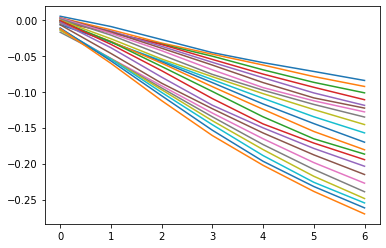

In [64]:
#residual plot

residuals = y_test-pred7LSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)
    

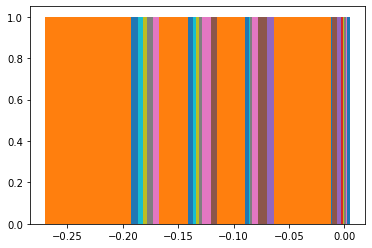

In [65]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

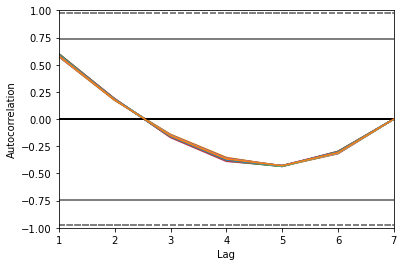

In [66]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)

In [ ]:
#BiLSTM

In [6]:
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):] 
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_5796/3905142482.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_5796/3905142482.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [7]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [12]:
n_past = 5
n_future =5
n_features = 1
X_train, y_train = split_series(train.values,n_past, n_future)

In [13]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [466]:
#define model
model = Sequential()
model.add(Bidirectional(LSTM(150, return_sequences=True), input_shape=(n_past, n_features)))
model.add(Bidirectional(LSTM(128,activation='relu')))
model.add(Dense(128))
model.add(Dense(n_future))
model.compile(loss='mean_squared_error', optimizer='Adam')

In [467]:
history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2, batch_size = 16)

Epoch 1/100
5/5 [==============================] - 12s 471ms/step - loss: 0.1403 - val_loss: 0.3759
Epoch 2/100
5/5 [==============================] - 0s 61ms/step - loss: 0.0516 - val_loss: 0.0229
Epoch 3/100
5/5 [==============================] - 0s 67ms/step - loss: 0.0156 - val_loss: 0.0324
Epoch 4/100
5/5 [==============================] - 0s 61ms/step - loss: 0.0055 - val_loss: 0.0418
Epoch 5/100
5/5 [==============================] - 0s 63ms/step - loss: 0.0094 - val_loss: 0.0648
Epoch 6/100
5/5 [==============================] - 0s 63ms/step - loss: 0.0040 - val_loss: 0.0139
Epoch 7/100
5/5 [==============================] - 0s 60ms/step - loss: 0.0026 - val_loss: 6.8164e-04
Epoch 8/100
5/5 [==============================] - 0s 61ms/step - loss: 0.0025 - val_loss: 0.0101
Epoch 9/100
5/5 [==============================] - 0s 64ms/step - loss: 0.0011 - val_loss: 0.0181
Epoch 10/100
5/5 [==============================] - 0s 63ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 11/100


In [10]:
#model.save('bilstm_3days.h5')
model=load_model("bilstm_3days.h5")

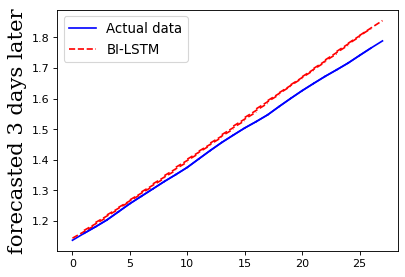

In [11]:
pred3BiLSTM=model.predict(X_test)
pred3BiLSTM = pred3BiLSTM.reshape((pred3BiLSTM.shape[0], pred3BiLSTM.shape[1],n_features))
from matplotlib.pyplot import figure
font1 = {'family':'Serif','color':'black','size':19}

figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3BiLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    plt.ylabel("forecasted 3 days later", fontdict = font1)
    plt.legend(['Actual data','BI-LSTM'],fontsize=12)
#plt.legend()       

In [12]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  0.031784719946312906
Day  2 :
MAE-E2D2 :  0.03047552885271929
Day  3 :
MAE-E2D2 :  0.02908042724294049


mean 0.030446892013990895


In [74]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  2.09388021353381
Day  2 :
MAE-E2D2 :  1.9608822136457753
Day  3 :
MAE-E2D2 :  1.8272182106152106


mean 1.9606602125982653


In [75]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


death
Day  1 :
MAE-E2D2 :  0.036243647889065554
Day  2 :
MAE-E2D2 :  0.03569772952353399
Day  3 :
MAE-E2D2 :  0.03507212907956919


mean 0.03567116883072291


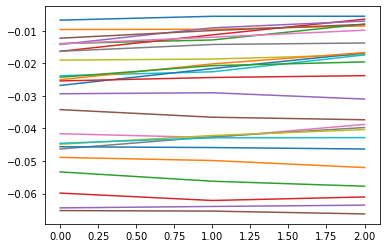

In [13]:
#residual plot

residuals = y_test-pred3BiLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

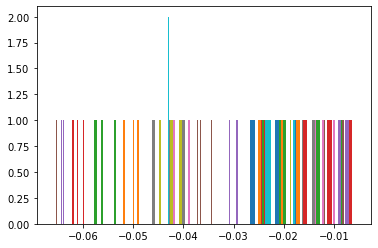

In [77]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

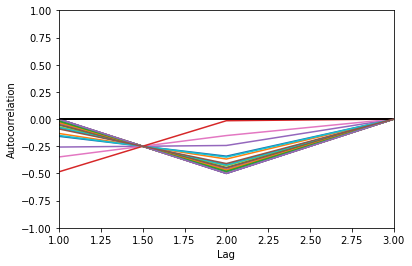

In [78]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)   

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

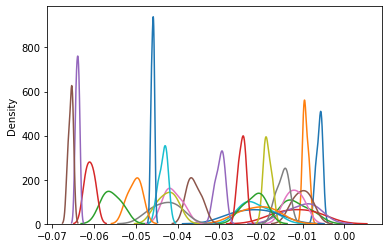

In [14]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [ ]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [14]:
#model.save('bilstm_5days.h5')
model=load_model("bilstm_5days.h5")

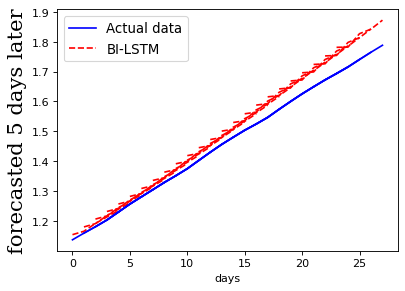

In [15]:
pred5BiLSTM=model.predict(X_test)
pred5BiLSTM= pred5BiLSTM.reshape((pred5BiLSTM.shape[0], pred5BiLSTM.shape[1],n_features))
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5BiLSTM[i],"red",linestyle='dashed')
    plt.xlabel("days")   
    plt.ylabel("forecasted 5 days later", fontdict = font1)
    plt.legend(['Actual data','BI-LSTM'],fontsize=12)
      

In [19]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

death
Day  1 :
MAE-E2D2 :  0.047370573542562654
Day  2 :
MAE-E2D2 :  0.030030550285330044
Day  3 :
MAE-E2D2 :  0.040396132257367656
Day  4 :
MAE-E2D2 :  0.03542789668839056
Day  5 :
MAE-E2D2 :  0.03634832551116546


mean 0.037914695656963274


In [84]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  3.225424275225034
Day  2 :
MAE-E2D2 :  1.976819641912301
Day  3 :
MAE-E2D2 :  2.6170426485881535
Day  4 :
MAE-E2D2 :  2.249895842290951
Day  5 :
MAE-E2D2 :  2.2533153576368843


mean 2.464499553130665


In [85]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


death
Day  1 :
MAE-E2D2 :  0.051550263011589076
Day  2 :
MAE-E2D2 :  0.03475471935546112
Day  3 :
MAE-E2D2 :  0.04664356215258984
Day  4 :
MAE-E2D2 :  0.04154967874037718
Day  5 :
MAE-E2D2 :  0.04403124105206183


mean 0.043705892862415816


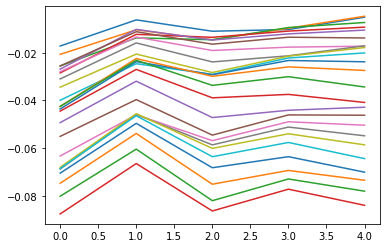

In [20]:
#residual plot

residuals = y_test-pred5BiLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

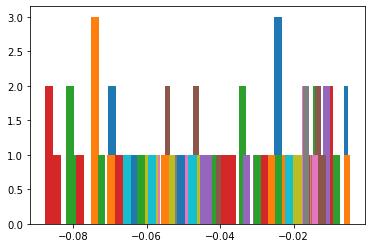

In [87]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

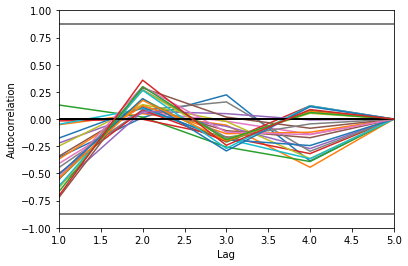

In [88]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

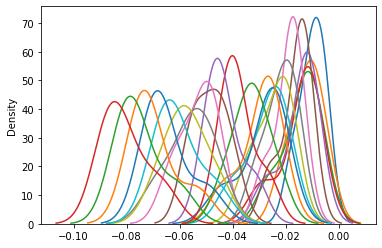

In [21]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [ ]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [91]:
#model.save('bilstm_7days1.h5')
model=load_model("bilstm_7days.h5")

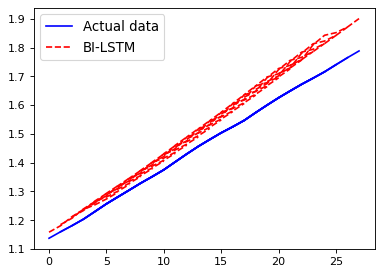

In [92]:
pred7BiLSTM=model.predict(X_test)
pred7BiLSTM = pred7BiLSTM.reshape((pred7BiLSTM.shape[0], pred7BiLSTM.shape[1],n_features))
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7BiLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 7 days later")
    plt.legend(['Actual data','BI-LSTM'],fontsize=12)
#plt.legend()       

In [93]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

death
Day  1 :
MAE-E2D2 :  0.052808684576944494
Day  2 :
MAE-E2D2 :  0.04979336639965308
Day  3 :
MAE-E2D2 :  0.06670407985157426
Day  4 :
MAE-E2D2 :  0.07147967898433824
Day  5 :
MAE-E2D2 :  0.06009404885484107
Day  6 :
MAE-E2D2 :  0.05586377770922035
Day  7 :
MAE-E2D2 :  0.057792548889329366


mean 0.059219455037985834


In [94]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  3.677600406826088
Day  2 :
MAE-E2D2 :  3.4097552144281806
Day  3 :
MAE-E2D2 :  4.49286454276211
Day  4 :
MAE-E2D2 :  4.72894338761614
Day  5 :
MAE-E2D2 :  3.890335433342418
Day  6 :
MAE-E2D2 :  3.544887641021162
Day  7 :
MAE-E2D2 :  3.6036898535147563


mean 3.906868068501551


In [95]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    



death
Day  1 :
MAE-E2D2 :  0.05679893478082822
Day  2 :
MAE-E2D2 :  0.05357115995853861
Day  3 :
MAE-E2D2 :  0.07169169921011327
Day  4 :
MAE-E2D2 :  0.07719575247596254
Day  5 :
MAE-E2D2 :  0.06615513165594089
Day  6 :
MAE-E2D2 :  0.062493827220407784
Day  7 :
MAE-E2D2 :  0.06523583748301204


mean 0.06473462039782905


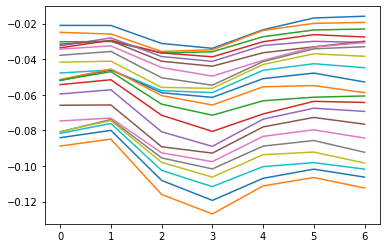

In [96]:
#residual plot

residuals = y_test-pred7BiLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

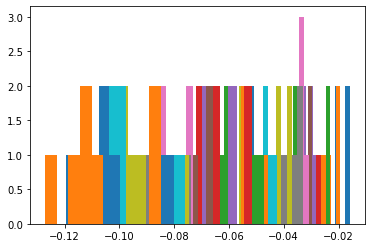

In [97]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

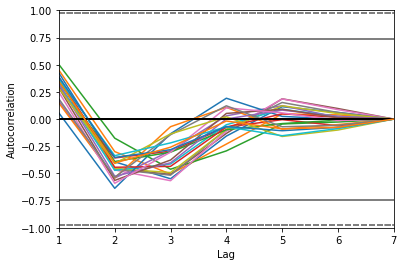

In [98]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [ ]:
#ConvLSTM

In [16]:
n_past=4
n_future=7
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):]
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s
    
    
    
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y) 


X_train, y_train = split_series(train.values,n_past, n_future)
X_test, y_test = split_series(test.values,n_past, n_future)

n_features = 1
n_seq = 2
n_steps = 2
X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_steps, n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_steps, n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_5796/427068468.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_5796/427068468.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [64]:
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(n_future))
model.compile(optimizer='adam', loss='mse')

In [496]:
history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False)

Epoch 1/100
5/5 [==============================] - 6s 152ms/step - loss: 0.1686 - val_loss: 0.6027
Epoch 2/100
5/5 [==============================] - 0s 27ms/step - loss: 0.1638 - val_loss: 0.5898
Epoch 3/100
5/5 [==============================] - 0s 25ms/step - loss: 0.1603 - val_loss: 0.5768
Epoch 4/100
5/5 [==============================] - 0s 26ms/step - loss: 0.1569 - val_loss: 0.5635
Epoch 5/100
5/5 [==============================] - 0s 25ms/step - loss: 0.1535 - val_loss: 0.5496
Epoch 6/100
5/5 [==============================] - 0s 25ms/step - loss: 0.1500 - val_loss: 0.5349
Epoch 7/100
5/5 [==============================] - 0s 29ms/step - loss: 0.1462 - val_loss: 0.5189
Epoch 8/100
5/5 [==============================] - 0s 26ms/step - loss: 0.1422 - val_loss: 0.5014
Epoch 9/100
5/5 [==============================] - 0s 25ms/step - loss: 0.1379 - val_loss: 0.4824
Epoch 10/100
5/5 [==============================] - 0s 25ms/step - loss: 0.1332 - val_loss: 0.4617
Epoch 11/100
5/5 [

In [100]:
#model.save('ConvLSTM_3days.h5')
model=load_model("ConvLSTM_3days.h5")

In [101]:
pred3ConvLSTM=model.predict(X_test)

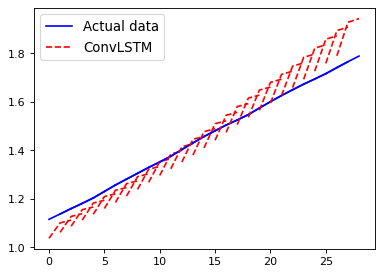

In [102]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3ConvLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 3 days later")
    plt.legend(['Actual data','ConvLSTM'],fontsize=12)


In [103]:
#MAE
from sklearn.metrics import mean_absolute_error
pred3ConvLSTM = pred3ConvLSTM.reshape((pred3ConvLSTM.shape[0], pred3ConvLSTM.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))     

death
Day  1 :
MAE-E2D2 :  0.04539592427801926
Day  2 :
MAE-E2D2 :  0.05487439850476398
Day  3 :
MAE-E2D2 :  0.05297622993320222


mean 0.051082184238661815


In [104]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  3.433969528693505
Day  2 :
MAE-E2D2 :  3.499380587973979
Day  3 :
MAE-E2D2 :  3.400204062854518


mean 3.4445180598406675


In [105]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    




death
Day  1 :
MAE-E2D2 :  0.051408363542470505
Day  2 :
MAE-E2D2 :  0.07279162770970889
Day  3 :
MAE-E2D2 :  0.06821987774382254


mean 0.06413995633200065


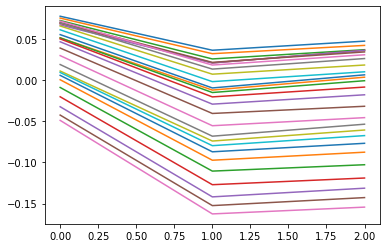

In [106]:
#residual plot

residuals = y_test-pred3ConvLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

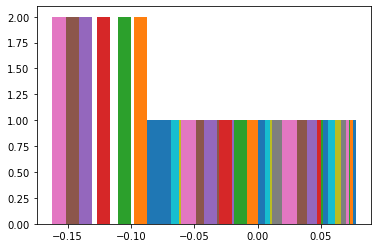

In [107]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

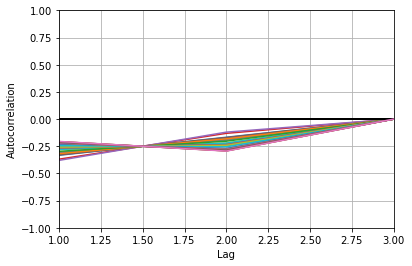

In [108]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [7]:
#model.save('ConvLSTM_5days.h5')
model=load_model("ConvLSTM_5days.h5")

In [8]:
pred5ConvLSTM=model.predict(X_test)

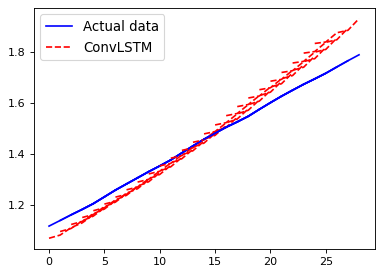

In [9]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5ConvLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 5 days later")
    plt.legend(['Actual data','ConvLSTM'],fontsize=12)


In [13]:
#MAE
from sklearn.metrics import mean_absolute_error
pred5ConvLSTM = pred5ConvLSTM.reshape((pred5ConvLSTM.shape[0], pred5ConvLSTM.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))     

death
Day  1 :
MAE-E2D2 :  0.047112590401831966
Day  2 :
MAE-E2D2 :  0.04502273575978172
Day  3 :
MAE-E2D2 :  0.046721840601368185
Day  4 :
MAE-E2D2 :  0.04525108025415594
Day  5 :
MAE-E2D2 :  0.04952053281652172


mean 0.04672575596673191


In [14]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    

death
Day  1 :
MAE-E2D2 :  3.198522245753184
Day  2 :
MAE-E2D2 :  3.1052570998540294
Day  3 :
MAE-E2D2 :  3.1044803635912603
Day  4 :
MAE-E2D2 :  3.0162066880387557
Day  5 :
MAE-E2D2 :  3.1576661848034497


mean 3.1164265164081355


In [115]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


death
Day  1 :
MAE-E2D2 :  0.05997341725387596
Day  2 :
MAE-E2D2 :  0.05412265721084247
Day  3 :
MAE-E2D2 :  0.058458834954946935
Day  4 :
MAE-E2D2 :  0.05386197573082525
Day  5 :
MAE-E2D2 :  0.06244191893612379


mean 0.05777176081732288


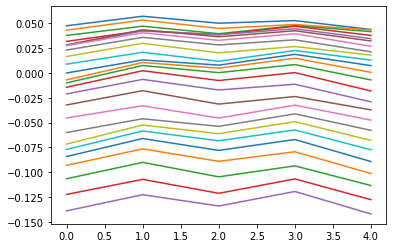

In [116]:
#residual plot

residuals = y_test-pred5ConvLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

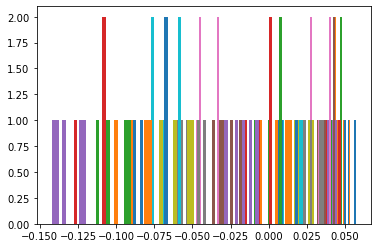

In [117]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

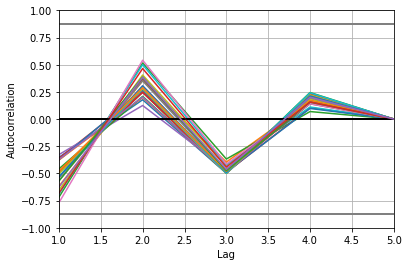

In [118]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [17]:
#model.save('ConvLSTM_7days.h5')
model=load_model("ConvLSTM_7days.h5")

In [18]:
pred7ConvLSTM=model.predict(X_test)

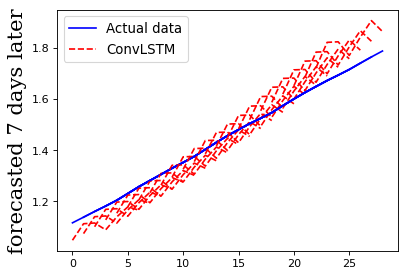

In [19]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7ConvLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    plt.ylabel("forecasted 7 days later", fontdict = font1)
    plt.legend(['Actual data','ConvLSTM'],fontsize=12)


In [19]:
#MAE
from sklearn.metrics import mean_absolute_error
pred7ConvLSTM = pred7ConvLSTM.reshape((pred7ConvLSTM.shape[0], pred7ConvLSTM.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))     

death
Day  1 :
MAE-E2D2 :  0.0404151140112833
Day  2 :
MAE-E2D2 :  0.05235606942519944
Day  3 :
MAE-E2D2 :  0.04553526470871954
Day  4 :
MAE-E2D2 :  0.054115164430545
Day  5 :
MAE-E2D2 :  0.04635532785507598
Day  6 :
MAE-E2D2 :  0.05209729280500606
Day  7 :
MAE-E2D2 :  0.0534410543047752


mean 0.04918789822008636


In [20]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    

death
Day  1 :
MAE-E2D2 :  3.03459152353456
Day  2 :
MAE-E2D2 :  3.4384038033836406
Day  3 :
MAE-E2D2 :  3.0462628407843737
Day  4 :
MAE-E2D2 :  3.9803984633830716
Day  5 :
MAE-E2D2 :  3.177981093895206
Day  6 :
MAE-E2D2 :  3.3462268800776975
Day  7 :
MAE-E2D2 :  3.6738530024287166


mean 3.385388229641038


In [125]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


death
Day  1 :
MAE-E2D2 :  0.04501272474907033
Day  2 :
MAE-E2D2 :  0.07000351390883712
Day  3 :
MAE-E2D2 :  0.05796958854878757
Day  4 :
MAE-E2D2 :  0.061704621362095965
Day  5 :
MAE-E2D2 :  0.05256121826132027
Day  6 :
MAE-E2D2 :  0.06472480179078678
Day  7 :
MAE-E2D2 :  0.05958812675342672


mean 0.05879494219633211


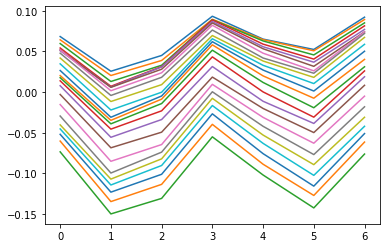

In [126]:
#residual plot

residuals = y_test-pred7ConvLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

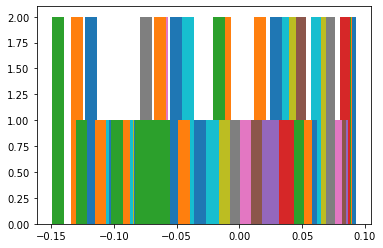

In [127]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

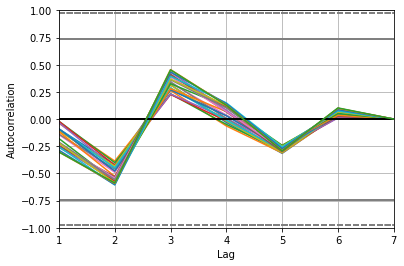

In [128]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [ ]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [ ]:
#GRU

In [21]:
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):] 
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_9848/3905142482.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_9848/3905142482.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [22]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [37]:
n_past = 5
n_future =7
n_features = 1
X_train, y_train = split_series(train.values,n_past, n_future)

In [38]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))

In [118]:
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (91, 5, 1)
y_train.shape:  (91, 3)
X_test.shape:  (26, 5, 1)
y_test.shape:  (26, 3)


In [88]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = n_future)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_gru = create_gru(64)

In [567]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        )
    return history
history_gru = fit_model(model_gru)


Epoch 1/100
5/5 [==============================] - 9s 291ms/step - loss: 0.1604 - val_loss: 0.5152
Epoch 2/100
5/5 [==============================] - 0s 24ms/step - loss: 0.1166 - val_loss: 0.3983
Epoch 3/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0828 - val_loss: 0.2706
Epoch 4/100
5/5 [==============================] - 0s 27ms/step - loss: 0.0468 - val_loss: 0.1405
Epoch 5/100
5/5 [==============================] - 0s 24ms/step - loss: 0.0194 - val_loss: 0.0398
Epoch 6/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0076 - val_loss: 0.0051
Epoch 7/100
5/5 [==============================] - 0s 26ms/step - loss: 0.0121 - val_loss: 0.0044
Epoch 8/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0091 - val_loss: 0.0048
Epoch 9/100
5/5 [==============================] - 0s 27ms/step - loss: 0.0069 - val_loss: 0.0098
Epoch 10/100
5/5 [==============================] - 0s 25ms/step - loss: 0.0058 - val_loss: 0.0133
Epoch 11/100
5/5 [

Epoch 84/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0026 - val_loss: 0.0068
Epoch 85/100
5/5 [==============================] - 0s 24ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 86/100
5/5 [==============================] - 0s 25ms/step - loss: 0.0026 - val_loss: 4.5995e-04
Epoch 87/100
5/5 [==============================] - 0s 24ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 88/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 89/100
5/5 [==============================] - 0s 25ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 90/100
5/5 [==============================] - 0s 21ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 91/100
5/5 [==============================] - 0s 21ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 92/100
5/5 [==============================] - 0s 23ms/step - loss: 0.0023 - val_loss: 0.0035
Epoch 93/100
5/5 [==============================] - 0s 25ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 

In [25]:
#model_gru.save('GRU_3days.h5')
model_gru=load_model("GRU_3days.h5")

In [26]:
pred3GRU=model_gru.predict(X_test)

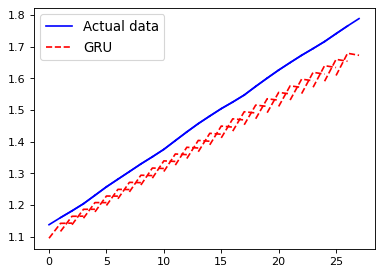

In [27]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3GRU[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 3 days later")
    plt.legend(['Actual data','GRU'],fontsize=12)


In [28]:
#MAE
from sklearn.metrics import mean_absolute_error
pred3GRU = pred3GRU.reshape((pred3GRU.shape[0], pred3GRU.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3GRU[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3GRU[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors)) 
    

death
Day  1 :
MAE-E2D2 :  0.0838498314687637
Day  2 :
MAE-E2D2 :  0.049948747829327456
Day  3 :
MAE-E2D2 :  0.07695382411685237


mean 0.0702508011383145


In [29]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))  


death
Day  1 :
MAE-E2D2 :  5.671658856406733
Day  2 :
MAE-E2D2 :  3.2868736997241284
Day  3 :
MAE-E2D2 :  5.0613499560552695


mean 4.673294170728711


In [139]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))  



death
Day  1 :
MAE-E2D2 :  0.08831959333858175
Day  2 :
MAE-E2D2 :  0.05407193023820706
Day  3 :
MAE-E2D2 :  0.08019925455437678


mean 0.07419692604372186


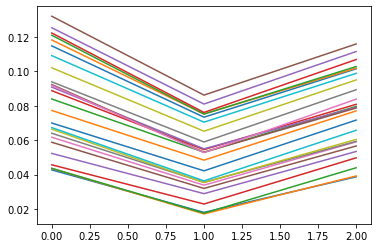

In [140]:
#residual plot

residuals = y_test-pred3GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

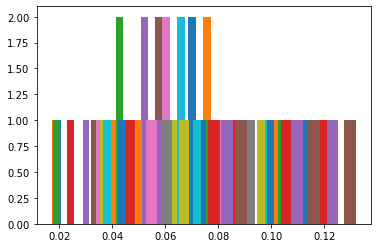

In [141]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

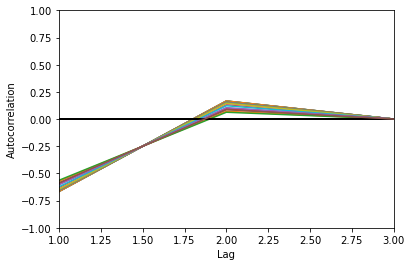

In [142]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [32]:
#model_gru.save('GRU_5days.h5')
model_gru=load_model("GRU_5days.h5")

In [33]:
pred5GRU=model_gru.predict(X_test)


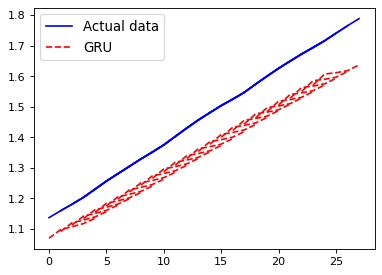

In [34]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5GRU[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 5 days later")
    plt.legend(['Actual data','GRU'],fontsize=12)


In [35]:
#MAE
from sklearn.metrics import mean_absolute_error
pred5GRU = pred5GRU.reshape((pred5GRU.shape[0], pred5GRU.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5GRU[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5GRU[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors)) 
    

death
Day  1 :
MAE-E2D2 :  0.09486431314344453
Day  2 :
MAE-E2D2 :  0.08728689280733404
Day  3 :
MAE-E2D2 :  0.10457644543371053
Day  4 :
MAE-E2D2 :  0.12039674966533105
Day  5 :
MAE-E2D2 :  0.1268722191449523


mean 0.1067993240389545


In [36]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))  


death
Day  1 :
MAE-E2D2 :  6.645052581458626
Day  2 :
MAE-E2D2 :  6.018834009070914
Day  3 :
MAE-E2D2 :  7.1048373396786495
Day  4 :
MAE-E2D2 :  8.059961712552926
Day  5 :
MAE-E2D2 :  8.370136555171207


mean 7.239764439586464


In [150]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))  



death
Day  1 :
MAE-E2D2 :  0.09657334521819506
Day  2 :
MAE-E2D2 :  0.08869874296243595
Day  3 :
MAE-E2D2 :  0.10596169110910304
Day  4 :
MAE-E2D2 :  0.12168176791019313
Day  5 :
MAE-E2D2 :  0.12794709367149468


mean 0.10817252817428438


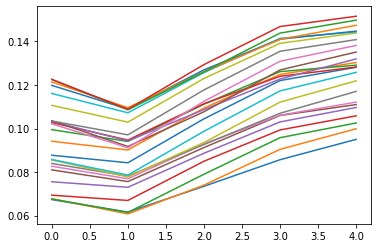

In [151]:
#residual plot

residuals = y_test-pred5GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

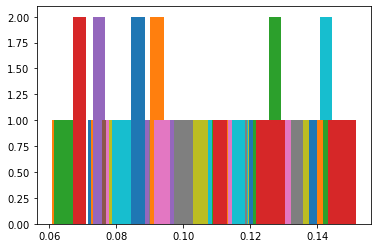

In [152]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

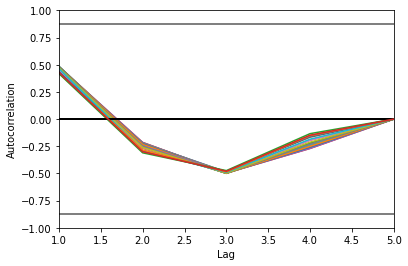

In [153]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [39]:
#model_gru.save('GRU_7days.h5')
model_gru=load_model("GRU_7days.h5")

In [40]:
pred7GRU=model_gru.predict(X_test)


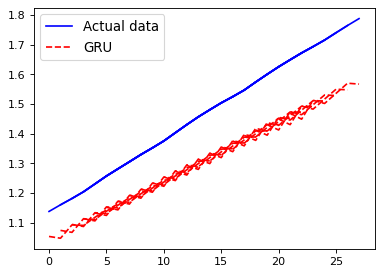

In [41]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7GRU[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 7days later") 
    plt.legend(['Actual data','GRU'],fontsize=12)

In [42]:
#MAE
from sklearn.metrics import mean_absolute_error
pred7GRU = pred7GRU.reshape((pred7GRU.shape[0], pred7GRU.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7GRU[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7GRU[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors)) 
    

death
Day  1 :
MAE-E2D2 :  0.12857629610161386
Day  2 :
MAE-E2D2 :  0.1654447821162216
Day  3 :
MAE-E2D2 :  0.13583639907152978
Day  4 :
MAE-E2D2 :  0.16649148056051982
Day  5 :
MAE-E2D2 :  0.16019942967742987
Day  6 :
MAE-E2D2 :  0.15530364449869866
Day  7 :
MAE-E2D2 :  0.1782758678361761


mean 0.15573255712316994


In [43]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))  


death
Day  1 :
MAE-E2D2 :  9.12006569504371
Day  2 :
MAE-E2D2 :  11.565051544413153
Day  3 :
MAE-E2D2 :  9.332616191715616
Day  4 :
MAE-E2D2 :  11.279178523163619
Day  5 :
MAE-E2D2 :  10.685855502176961
Day  6 :
MAE-E2D2 :  10.208738359830711
Day  7 :
MAE-E2D2 :  11.544299728315686


mean 10.533686506379922


In [161]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))  



death
Day  1 :
MAE-E2D2 :  0.1319166109294467
Day  2 :
MAE-E2D2 :  0.16888274370802045
Day  3 :
MAE-E2D2 :  0.13870841104166037
Day  4 :
MAE-E2D2 :  0.16921205306064527
Day  5 :
MAE-E2D2 :  0.16253301372175652
Day  6 :
MAE-E2D2 :  0.15717662763273235
Day  7 :
MAE-E2D2 :  0.1801902781719082


mean 0.15837424832373853


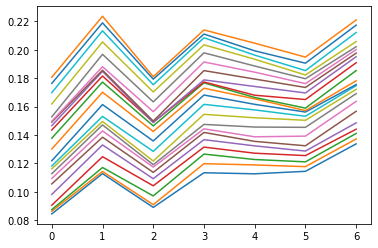

In [162]:
#residual plot

residuals = y_test-pred7GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

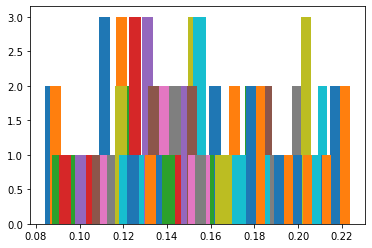

In [163]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

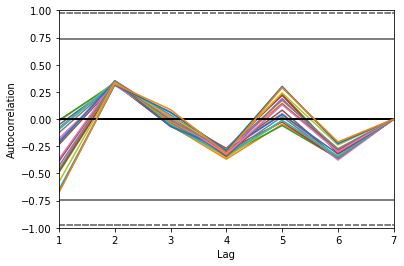

In [164]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

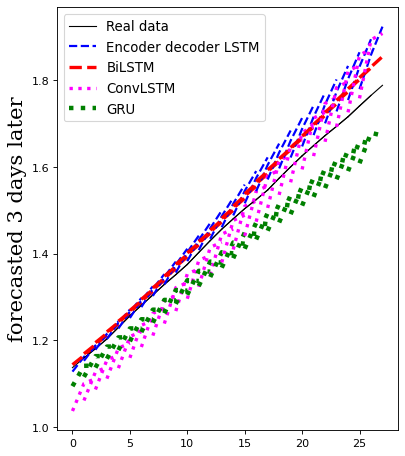

In [118]:
from matplotlib.pyplot import figure
figure(figsize=(5.5,7), dpi=80)
font1 = {'family':'Serif','color':'black','size':19}
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"black",linewidth=1)
    plt.plot(range(i,i+n_future),pred3LSTM[i],"blue",linestyle='dashed',linewidth=2)
    plt.plot(range(i,i+n_future),pred3BiLSTM[i],"red",linestyle='dashed',linewidth=3)
    plt.plot(range(i,i+n_future),pred3ConvLSTM[i],"magenta",linestyle='dotted',linewidth=3)
    plt.plot(range(i,i+n_future),pred3GRU[i],"green",linestyle='dotted',linewidth=4)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 3 days later", fontdict = font1)
    plt.legend(['Real data','Encoder decoder LSTM','BiLSTM','ConvLSTM','GRU'],fontsize=12)
#plt.legend()

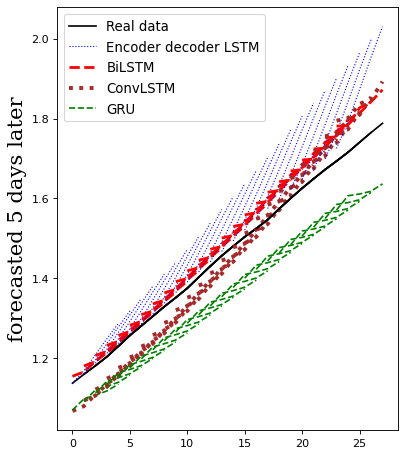

In [115]:
from matplotlib.pyplot import figure
figure(figsize=(5.5,7), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"black")
    plt.plot(range(i,i+n_future),pred5LSTM[i],"blue",linestyle='dotted',linewidth=1)
    plt.plot(range(i,i+n_future),pred5BiLSTM[i],"red",linestyle='dashed',linewidth=2.5)
    plt.plot(range(i,i+n_future),pred5ConvLSTM[i],"brown",linestyle='dotted',linewidth=3.5)
    plt.plot(range(i,i+n_future),pred5GRU[i],"green",linestyle='dashed')
    #plt.xlabel("days")   
    plt.ylabel("forecasted 5 days later", fontdict = font1)
    plt.legend(['Real data','Encoder decoder LSTM','BiLSTM','ConvLSTM','GRU'],fontsize=12)
#plt.legend()

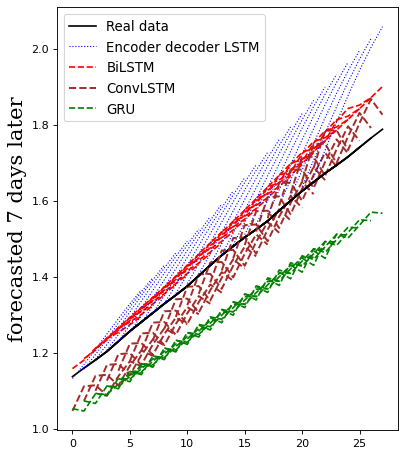

In [111]:
from matplotlib.pyplot import figure
figure(figsize=(5.5,7), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"black")
    plt.plot(range(i,i+n_future),pred7LSTM[i],"blue",linestyle='dotted',linewidth=1)
    plt.plot(range(i,i+n_future),pred7BiLSTM[i],"red",linestyle='dashed')
    plt.plot(range(i,i+n_future),pred7ConvLSTM[i],"brown",linestyle='dashed',linewidth=1.75)
    plt.plot(range(i,i+n_future),pred7GRU[i],"green",linestyle='dashed')
    #plt.xlabel("days")   
    plt.ylabel("forecasted 7 days later", fontdict = font1)
    plt.legend(['Real data','Encoder decoder LSTM','BiLSTM','ConvLSTM','GRU'],fontsize=12)
#plt.legend()